In [23]:
import sys
import os
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams, cycler
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import xarray as xr
import geopandas as gpd
import rioxarray
from xeofs.xarray import EOF
import gc
import collections
import statsmodels.api as sm
import scipy
from sklearn.metrics import mean_squared_error
from math import sqrt
from itertools import product
import pyproj
from shapely.geometry import mapping
from xarrayutils.utils import linear_trend, xr_linregress
import pandas as pd
import cmocean
from matplotlib import animation, rc

# Third-party dependencies
# NOTE: Local xeofs to be submitted as pull-request (addition of xeofs.model.reconstruct_randomized_X method)
from xeofs.xarray import EOF
from xarrayutils.utils import linear_trend

In [51]:
# Define local plotting parameters
#sns.set_theme(style="whitegrid")
#sns.set_theme(style="ticks")
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
plt.rcParams.update({'font.size': 15})
plt.rc('font', family='sans-serif') 
plt.rc('font', serif='Helvetica Neue')
plt.rc('text', usetex=True)

## Define directories

In [3]:
# To update following with relative repository paths once data and code is up on Zenodo
# Current version uses the project template on Github.

# Define project repo path
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'

# DATA FILE PATHS
# Data containing regridded flux and SSH for 150 years
regriddedFluxSSH_filepath = 'data/interim/RegriddedFluxSSH.nc'
# File contains all defined ice shelves
iceShelvesShape_filepath = 'data/interim/iceShelves.geojson'

# Relative directory paths for Data and Figures
figures_folderpath = 'reports/figures/'
interim_data_folder = 'data/interim/'
flux_dedrafted_data_path = 'dedrafted_flux_IMBIE/'
randomized_realizations_path = 'randomized_realizations/'
flux_dedrafted_iceshelves_data_path = 'iceshelves_dedrafted_flux/'
reconstructions_neofs_path = 'reconstructions_neofs/'
cise_file_path = 'cise_data/'

## Input data files and catchment masks for ice shelves

### Catchment boundary masks

In [49]:
# Catchment boundary masks for Antarctica, taken from ice shelf definitions in MPAS-Dev/geometric-features
# Source: https://github.com/MPAS-Dev/geometric_features/tree/main/geometric_data
# These have been combined into one file with 133 defined regions (polygons and multipolygons), 
# readable via the Geopandas package

# Read geoJSON region feature file as GeoDataFrame
iceshelvesmask = gpd.read_file(inDirName + iceShelvesShape_filepath)

# Convert to south polar stereographic projection
#icems = iceshelvesmask.to_crs({'init': 'epsg:3031'}); # This has been deprecated
icems = iceshelvesmask.to_crs('epsg:3031');
crs = ccrs.SouthPolarStereo();

### Plot catchment boundaries

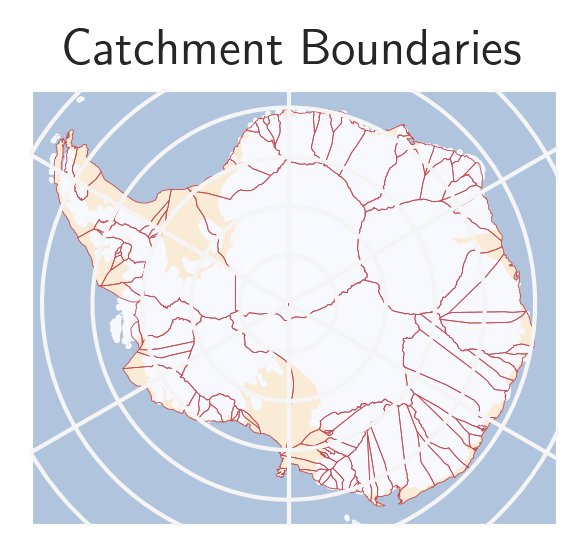

In [52]:
# Plot boundaries

plt.figure(figsize=(5,5))
ax1 = plt.subplot(121,projection=ccrs.SouthPolarStereo())
ax1.gridlines(color='whitesmoke',zorder=4)
icems[34:133].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=1)
icems[34:133].boundary.plot(ax=ax1,color='r', linewidth=0.2,zorder=3)
#icems[34:133].boundary.plot(ax=ax1,linewidth=0.25,color='lightgray',zorder=4)
#ax1.coastlines(resolution='10m', zorder=6,linewidth=0.75)
ax1.patch.set_facecolor(color='lightsteelblue')
#ax1.add_feature(cartopy.feature.LAND, color='ghostwhite')
ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=2)
plt.title('Catchment Boundaries');

### Ocean forcing data

In [5]:
# Original forcing data: raw MPAS-O output, mapped to the 10km resolution grid
# flux is freshwater flux
# ssh is sea surface height, used here as a proxy for ice draft / depth.

# ssh is used to plot the scatterplot of flux vs. draft for different ice shelves 
# and as input for the linear regression used in "dedrafting" the dataset

regridded_data = xr.open_dataset(inDirName+regriddedFluxSSH_filepath)
flux = regridded_data.timeMonthly_avg_landIceFreshwaterFlux
ssh = regridded_data.timeMonthly_avg_ssh

# Pre-processed data: detrended, deseasonalized, dedrafted
flux_clean = xr.open_dataset(inDirName+interim_data_folder+'flux_clean')
flux_clean = flux_clean.timeMonthly_avg_landIceFreshwaterFlux

# Dedrafted flux
flux_dedrafted = xr.open_dataset(inDirName+
                                 interim_data_folder+
                                 flux_dedrafted_iceshelves_data_path+'iceshelves_dedrafted_total.nc')
flux_dedrafted = flux_dedrafted.timeMonthly_avg_landIceFreshwaterFlux

# Flux datapoints extracted for individual ice shelves, used for the scatter plots
catchments_scatter = np.load(inDirName+interim_data_folder+"catchments_scatter.npy")
catchments_scatter_xr = xr.DataArray(catchments_scatter,dims={'basin','x','y'})

# Add reconstructed datasets - seed random

### Plot sample data for specific ice shelves (melt rate draft dependence)

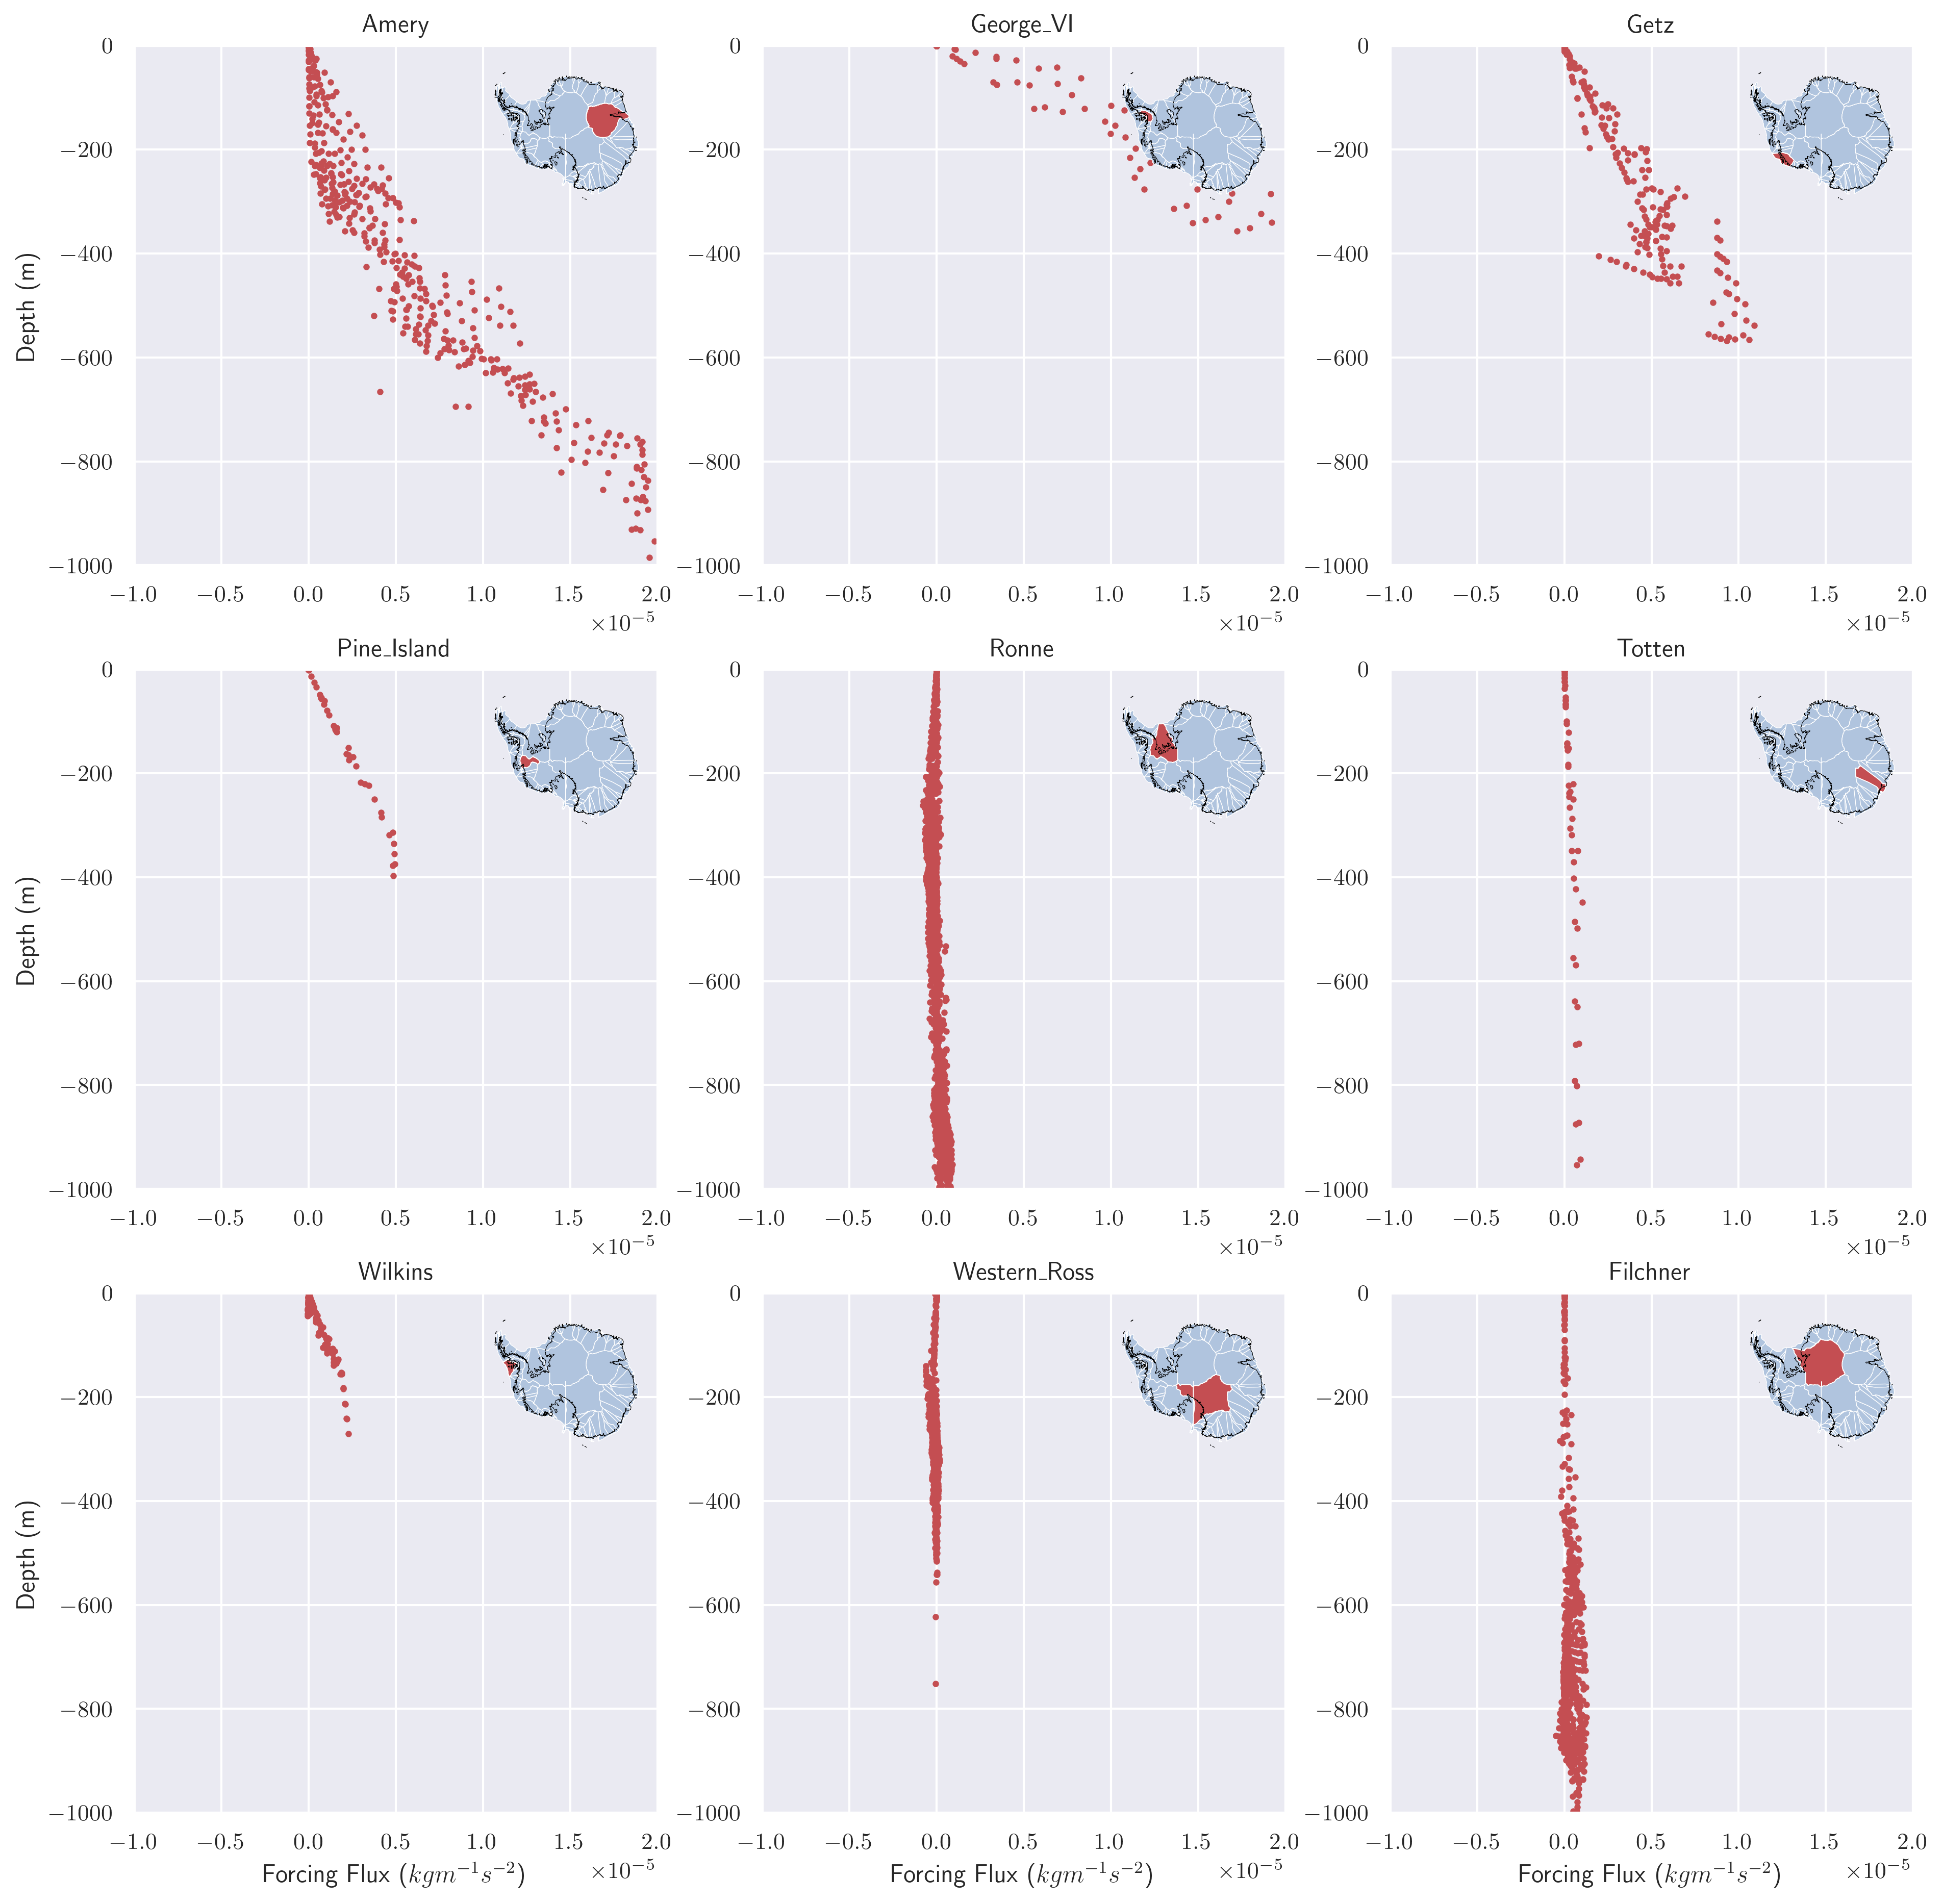

In [36]:
# Figure: Melt rate draft dependence for select catchments
catchments = np.array([1,27,28,61,70,83,94,71,22])

# Amery = 1
# George VI = 27
# Getz = 28
# Pine Island = 61
# Ronne = 70
# Totten = 83
# Wilkins = 94
# Western Ross = 71
# Filchner = 22
# Thwaites = 81
# Eastern_Ross = 72

#fig, ax = plt.subplots(1, 1, figsize=[15, 15],subplot_kw={'projection': ccrs.SouthPolarStereo()})
fig, axs = plt.subplots(3,3, figsize=[15, 15])
axs=axs.ravel()

#axins = inset_axes(ax, width="20%", height="20%")
#axins = axs[0].inset_axes([0.65, 0.6, 0.25, 0.25])

#sns.set_theme(style="whitegrid")

for i in range(9):
    axs[i].scatter(catchments_scatter[catchments[i]],ssh[1],color='r',s=4)
    #axs[i].set_xlabel('Melt Flux (kg / m2 / s)')
    #axs[i].set_ylabel('Depth (m)')
    axs[i].set_ylim(-1000,0)
    axs[i].set_xlim(-1e-5,2e-5)
    axs[i].set_title(icems.name[33+catchments[i]])
    axins = inset_axes(axs[i],width="30%", height="30%", loc="upper right", 
                       axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                       axes_kwargs=dict(projection=ccrs.SouthPolarStereo()))
    icems[33:133].plot(ax=axins,linewidth=0.3,color='lightsteelblue')
    axins.coastlines(resolution='10m',linewidth=0.25)
    icems.loc[[33+catchments[i]],'geometry'].plot(ax=axins,color='r',linewidth=0.4)
    axins.set_axis_off();

axs[0].set_ylabel('Depth (m)'); # Ice Draft?
axs[3].set_ylabel('Depth (m)');
axs[6].set_ylabel('Depth (m)');


axs[6].set_xlabel('Forcing Flux ($kg m^{-1}s^{-2}$)');
axs[7].set_xlabel('Forcing Flux ($kg m^{-1}s^{-2}$)');
axs[8].set_xlabel('Forcing Flux ($kg m^{-1}s^{-2}$)');
# TODO: Polar Stereographic Projection for inset map
# This is more complicated than expected. Remains rectilinear


# TODO: Convert to m SLE units for flux

# Pre-Process

In [ ]:
flux_ts = flux.sum(['x','y'])
flux_dedrafted_ts = flux_dedrafted.sum(['x','y'])

# Processed data time series
flux_clean_ts = flux_clean.sum(['x','y'])

In [ ]:
# Remove temporal mean
# Is this necessary?
flux_demeaned = flux - flux.mean('time')
flux_demeaned_ts = flux_demeaned.sum(['x','y'])

## Remove seasonality

In [ ]:
# Deseasonalize
# Remove climatologies to isolate anomalies, i.e., internal variability
flux_month = flux_dedrafted.groupby("time.month")
flux_clm = flux_month.mean("time") # Climatologies
flux_anm = flux_month - flux_clm # Deseasonalized anomalies

In [ ]:
flux_clm_ts = flux_clm.sum(['x','y'])
flux_anm_ts = flux_anm.sum(['x','y'])

In [ ]:
plt.figure(figsize=(25,6))
plt.plot(flux_ts[300:])
plt.plot(flux_dedrafted_ts[300:])
#plt.plot(flux_clean_ts)
plt.plot(flux_anm_ts[300:])

In [ ]:
# Sanity check, as "flux_clean.nc" was created earlier. The difference here is purely numerical.

plt.figure(figsize=(25,6))
plt.plot(flux_clean_ts - flux_anm_ts[300:])

# EOF/PCA Decomposition

### Data Normalization

In [ ]:
flux_clean_tmean = flux_clean.mean('time')
flux_clean_tstd = flux_clean.std('time')

flux_clean_demeaned = flux_clean - flux_clean_tmean
# Why does this introduce a non-zero change? (Artefact of flux variable dimensions?)
flux_clean_normalized = flux_clean_demeaned/flux_clean_tstd

In [ ]:
flux_clean_normalized = flux_clean/flux_clean_tstd

In [ ]:
flux_clean_normalized_ts = flux_clean_normalized.mean(['x','y'])

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(flux_clean_normalized_ts,color = '#44546A', linewidth=2)
plt.title('Anomalies / Internal Variability Component (Normalized)')
plt.ylabel('Standard Deviation Units')
plt.xlabel('Time (months)')

### Spatial Decomposition: EOF Analysis

In [ ]:
%%time
model = EOF(flux_clean_normalized)
model.solve()
eofs = model.eofs()
pcs = model.pcs()
nmodes = model.n_modes
varexpl = model.explained_variance_ratio()

In [ ]:
pcs_eig = model.pcs(1)
pcs_sng = model.pcs(2)

In [ ]:
sns.set_theme(style="white")

In [ ]:
# Figure: Dominant EOF modes
fg = eofs[:,:,0:2].plot(aspect=2,
                        size=8,
                        col="mode", 
                        col_wrap=2,
                        cmap='cmo.balance',
                        subplot_kws=dict(projection=ccrs.SouthPolarStereo()))

[ax.coastlines() for ax in fg.axes.flatten()]
# TODO: Redefine vmax, vmin 

In [ ]:
# Figure: Dominant EOF modes with their respective Projection Co-efficients

fg_eofs = eofs[:,:,0:2].plot(aspect=2,
                        size=8,
                        col="mode", 
                        col_wrap=2,
                        subplot_kws=dict(projection=ccrs.SouthPolarStereo()))
fg_pcs = pcs[:,0:2].plot(aspect=2,size=8,col="mode",col_wrap=2)